In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import train_test_split
import catboost

C:\Users\Yingting-PC\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
os.chdir('E:\personal project\Lending Club')
df = pd.read_csv('LoanStats3d.csv',dtype='str',encoding='latin-1')
df=df.loc[df.loan_status!='Current',:]
df.shape

(255118, 145)

In [4]:
# Find and filter out the features that have more 50% of missing value 
delete_col=df.isnull().sum()[df.isnull().sum()/len(df)>0.5].index.tolist()
df.drop(delete_col,inplace=True,axis=1)
df.shape

(255118, 88)

In [5]:
# variables will not be used for applications model
not_used_cols=['grade', 'sub_grade','int_rate','funded_amnt','funded_amnt_inv','issue_d','pymnt_plan','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt',
'collections_12_mths_ex_med','policy_code','delinq_amnt','hardship_flag','debt_settlement_flag','last_credit_pull_d']

In [6]:
df.drop(not_used_cols,inplace=True,axis=1)
df.reset_index(drop=True,inplace=True)
df.shape

(255118, 64)

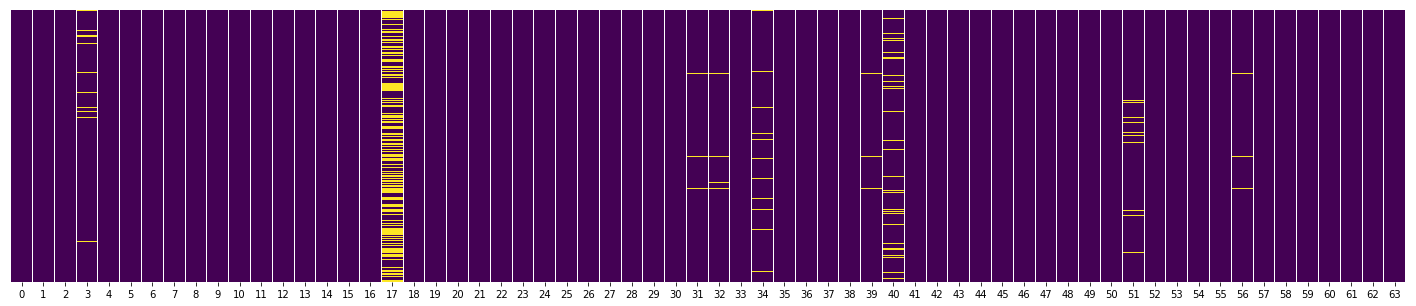

In [45]:
plt.figure(figsize=(25,5)) 
sns.set_context(font_scale=10)   
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis',xticklabels=list(range(len(df.columns))))

In [7]:
# remove units
df.revol_util=df.revol_util.str[:-1]
df.term=df.term.str[:3]

df.emp_length[(df.emp_length!='1 year')&(df.emp_length!='< 1 year')&(df.emp_length!='10+ years')]=df.emp_length[(df.emp_length!='1 year')&(df.emp_length!='< 1 year')&(df.emp_length!='10+ years')].str[:-6]
df.emp_length[df.emp_length=='< 1 year']=df.emp_length[df.emp_length=='< 1 year'].str[:-5]
df.emp_length[df.emp_length=='1 year']=df.emp_length[df.emp_length=='1 year'].str[:-5]
df.emp_length[df.emp_length=='10+ years']=df.emp_length[df.emp_length=='10+ years'].str[:-7]
# '<1 year'-->0, '10+ years'-->10
df.emp_length[df.emp_length=='< 1']=0
df.emp_length[df.emp_length=='']=np.nan

In [8]:
# good loans(0) and bad loan(1) 
df.loan_status.value_counts()

Fully Paid            183593
Charged Off            62042
Late (31-120 days)      5485
In Grace Period         2943
Late (16-30 days)       1033
Default                   22
Name: loan_status, dtype: int64

In [9]:
# good loans(0) and bad loan(1) 
df['label']='0'
df.loc[df.loan_status.isin(['Charged Off','Late (31-120 days)','Default']),'label']='1'

In [10]:
df.label.value_counts()

0    187569
1     67549
Name: label, dtype: int64

In [11]:
# transform date into duration (in years)
earl_d=df.earliest_cr_line
earl_y=[datetime.strptime(x,'%b-%y').year for x in earl_d]
dur_y=np.repeat(2015,len(earl_y))-earl_y

In [12]:
df['dur_y']=dur_y

In [13]:
df.isnull().sum()[df.isnull().sum()>0]

emp_title                  14093
emp_length                 14080
title                         67
dti                            2
mths_since_last_delinq    122809
revol_util                   113
bc_open_to_buy              2582
bc_util                     2763
mo_sin_old_il_acct          6936
mths_since_recent_bc        2469
mths_since_recent_inq      22908
num_rev_accts                  1
num_tl_120dpd_2m           11744
percent_bc_gt_75            2753
dtype: int64

In [14]:
df.fillna(-999,inplace=True)

In [15]:
# exclude 'zip_code', 'emp_title','disbursement_method','title','earliest_cr_line'
l_int=['loan_amnt','emp_length','delinq_2yrs','inq_last_6mths',
      'mths_since_last_delinq','open_acc','pub_rec','revol_bal','total_acc','acc_now_delinq','tot_coll_amt',
      'tot_cur_bal','total_rev_hi_lim','acc_open_past_24mths','avg_cur_bal', 'bc_open_to_buy','chargeoff_within_12_mths', 
       'mo_sin_old_il_acct','mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl','mort_acc', 
       'mths_since_recent_bc', 'mths_since_recent_inq','num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl','num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 
       'num_tl_120dpd_2m','num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m','pub_rec_bankruptcies','tax_liens', 
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit','total_il_high_credit_limit','dur_y']
l_float=['annual_inc','installment','dti','revol_util','bc_util','pct_tl_nvr_dlq', 'percent_bc_gt_75']
l_object=['term','home_ownership','verification_status', 'loan_status', 'purpose', 
          'addr_state', 'initial_list_status', 'application_type', 'label']

In [16]:
for i in l_int:
    df[i]=df[i].astype(int)
for i in l_float:
    df[i]=df[i].astype(float)
for i in l_object:
    df[i]=df[i].astype(object)

In [17]:
len(l_float)+len(l_int)+len(l_object)

61

In [100]:
dff=df.drop(['loan_status','zip_code', 'emp_title','disbursement_method','title','earliest_cr_line'],axis=1)

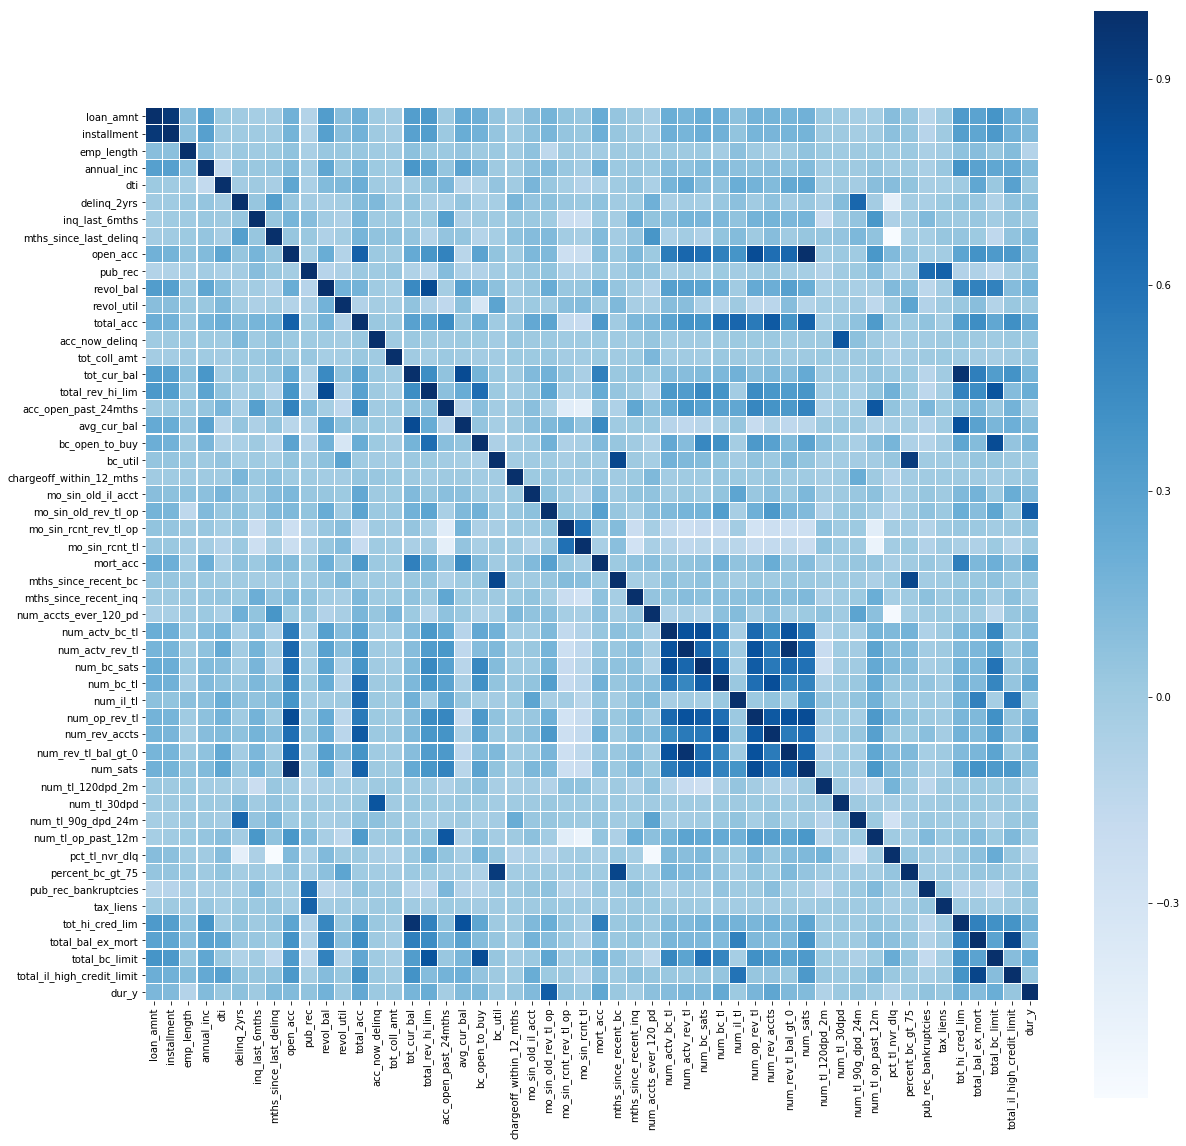

In [59]:
corr=dff.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr,cmap=plt.cm.Blues,square=True,annot_kws={'size':8},linewidths=0.1)

In [24]:
#annual_inc--> log(annual_inc)
#dff['log_inc']=np.log10(dff.annual_inc)
#dff.loc[np.isinf(dff.log_inc)==True,'log_inc']=0.0

C:\Users\Yingting-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


In [19]:
l_float=dff.select_dtypes(include=['float']).columns.tolist()

C:\Users\Yingting-PC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


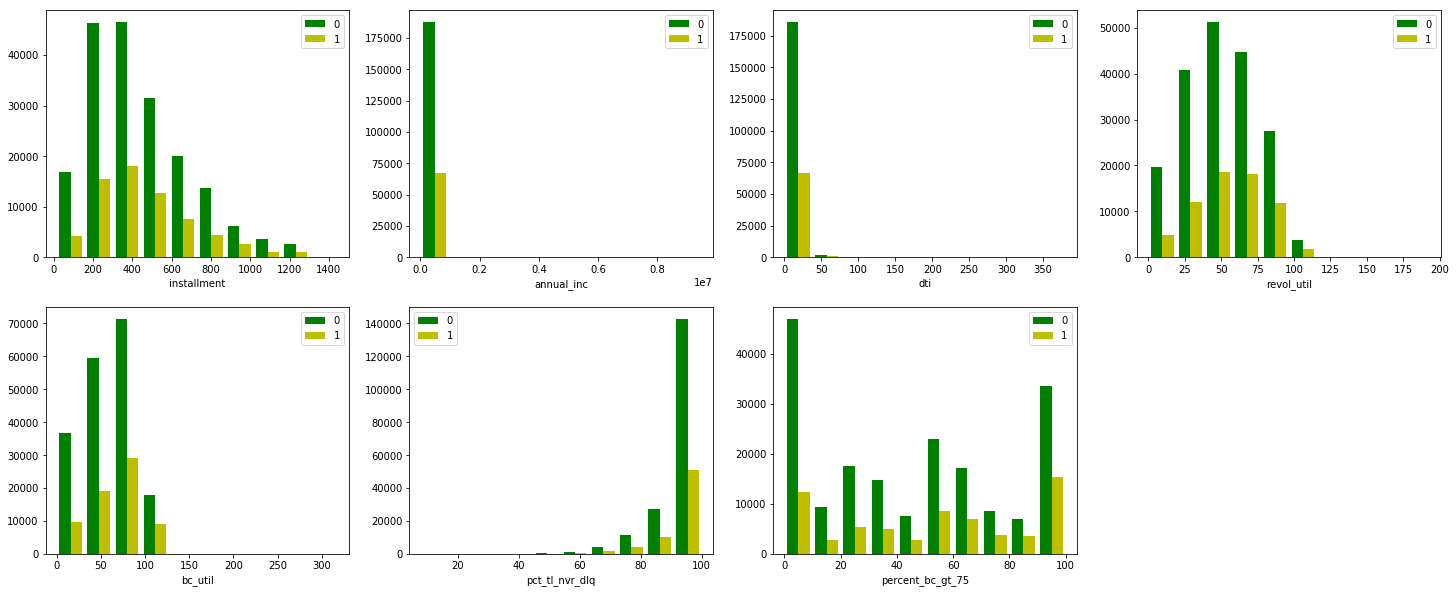

In [20]:
fig = plt.figure(figsize=(25,10))
for i in range(len(l_float)):
    ax=fig.add_subplot(2, 4, i+1)
    x1=dff[dff['label']=='0'][l_float[i]]
    x2=dff[dff['label']=='1'][l_float[i]]
    x1=x1[x1!=-999]
    x2=x2[x2!=-999]
    ax.hist([x1, x2], color=['g','y'], label=['0','1'])
    ax.set_xlabel(l_float[i])
    ax.legend()

In [47]:
dff['inc_level']=0
dff.loc[dff.annual_inc<=np.percentile(dff.annual_inc,25),'inc_level']='low'
dff.loc[(dff.annual_inc>np.percentile(dff.annual_inc,25))&(dff.annual_inc<=np.percentile(dff.annual_inc,50)),'inc_level']='med_low'
dff.loc[(dff.annual_inc>np.percentile(dff.annual_inc,50))&(dff.annual_inc<=np.percentile(dff.annual_inc,75)),'inc_level']='med_hig'
dff.loc[(dff.annual_inc>np.percentile(dff.annual_inc,75)),'inc_level']='hig'

In [76]:
dff['dti_level']=0
dff.loc[dff.dti<=np.percentile(dff.dti,25),'dti_level']='low'
dff.loc[(dff.dti>np.percentile(dff.dti,25))&(dff.dti<=np.percentile(dff.dti,50)),'dti_level']='med_low'
dff.loc[(dff.dti>np.percentile(dff.dti,50))&(dff.dti<=np.percentile(dff.dti,75)),'dti_level']='med_hig'
dff.loc[(dff.dti>np.percentile(dff.dti,75)),'dti_level']='hig'
dff.loc[dff.dti==-999,'dti_level']='-999'

In [86]:
dff['revol_util_level']=0
dff.loc[dff.revol_util<=np.percentile(dff.revol_util,25),'revol_util_level']='low'
dff.loc[(dff.revol_util>np.percentile(dff.revol_util,25))&(dff.revol_util<=np.percentile(dff.revol_util,50)),'revol_util_level']='med_low'
dff.loc[(dff.revol_util>np.percentile(dff.revol_util,50))&(dff.revol_util<=np.percentile(dff.revol_util,75)),'revol_util_level']='med_hig'
dff.loc[(dff.revol_util>np.percentile(dff.revol_util,75)),'revol_util_level']='hig'
dff.loc[dff.revol_util==-999,'revol_util_level']='-999'

In [92]:
def float_2_cat(new_col,old_col):
    dff[new_col]=0
    dff.loc[dff[old_col]<=np.percentile(dff[old_col],25),new_col]='low'
    dff.loc[(dff[old_col]>np.percentile(dff[old_col],25))&(dff[old_col]<=np.percentile(dff[old_col],50)),new_col]='med_low'
    dff.loc[(dff[old_col]>np.percentile(dff[old_col],50))&(dff[old_col]<=np.percentile(dff[old_col],75)),new_col]='med_hig'
    dff.loc[(dff[old_col]>np.percentile(dff[old_col],75)),new_col]='hig'
    dff.loc[dff[old_col]==-999,new_col]='-999'

In [101]:
for i in dff.select_dtypes(include=['float']).columns:
    float_2_cat(i+'_level',i)

In [102]:
dff.columns

Index(['loan_amnt', 'term', 'installment', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dlq', 'percent

In [81]:
dff.dti_level.value_counts()

med_low    63816
low        63790
med_hig    63788
hig        63722
-999           2
Name: dti_level, dtype: int64

In [46]:
np.percentile(dff.annual_inc,25)

46000.0

In [44]:
b=dff[dff.annual_inc<=200000]
c=dff[(dff.annual_inc>200000)]

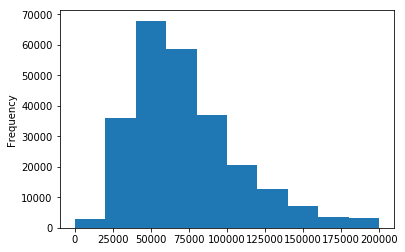

In [45]:
b.annual_inc.plot(kind='hist')

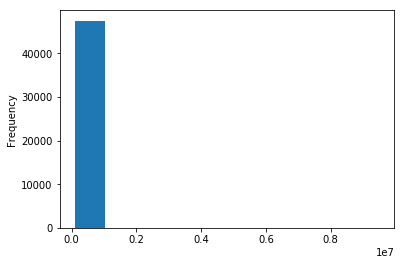

In [41]:
c.annual_inc.plot(kind='hist')

#### bining 'annual_inc','dti','bc_until','pct_tl_nvr_dlq'?

### VIF
.....

In [61]:
# according to vif, exclude: 
dff.drop(['num_sats','tot_cur_bal','installment','total_acc','num_rev_tl_bal_gt_0',
          'revol_bal','num_op_rev_tl','num_rev_accts','bc_open_to_buy'],axis=1,inplace=True)
dff.shape

In [70]:
l_int=dff.select_dtypes(include=['int']).columns.tolist()

C:\Users\Yingting-PC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


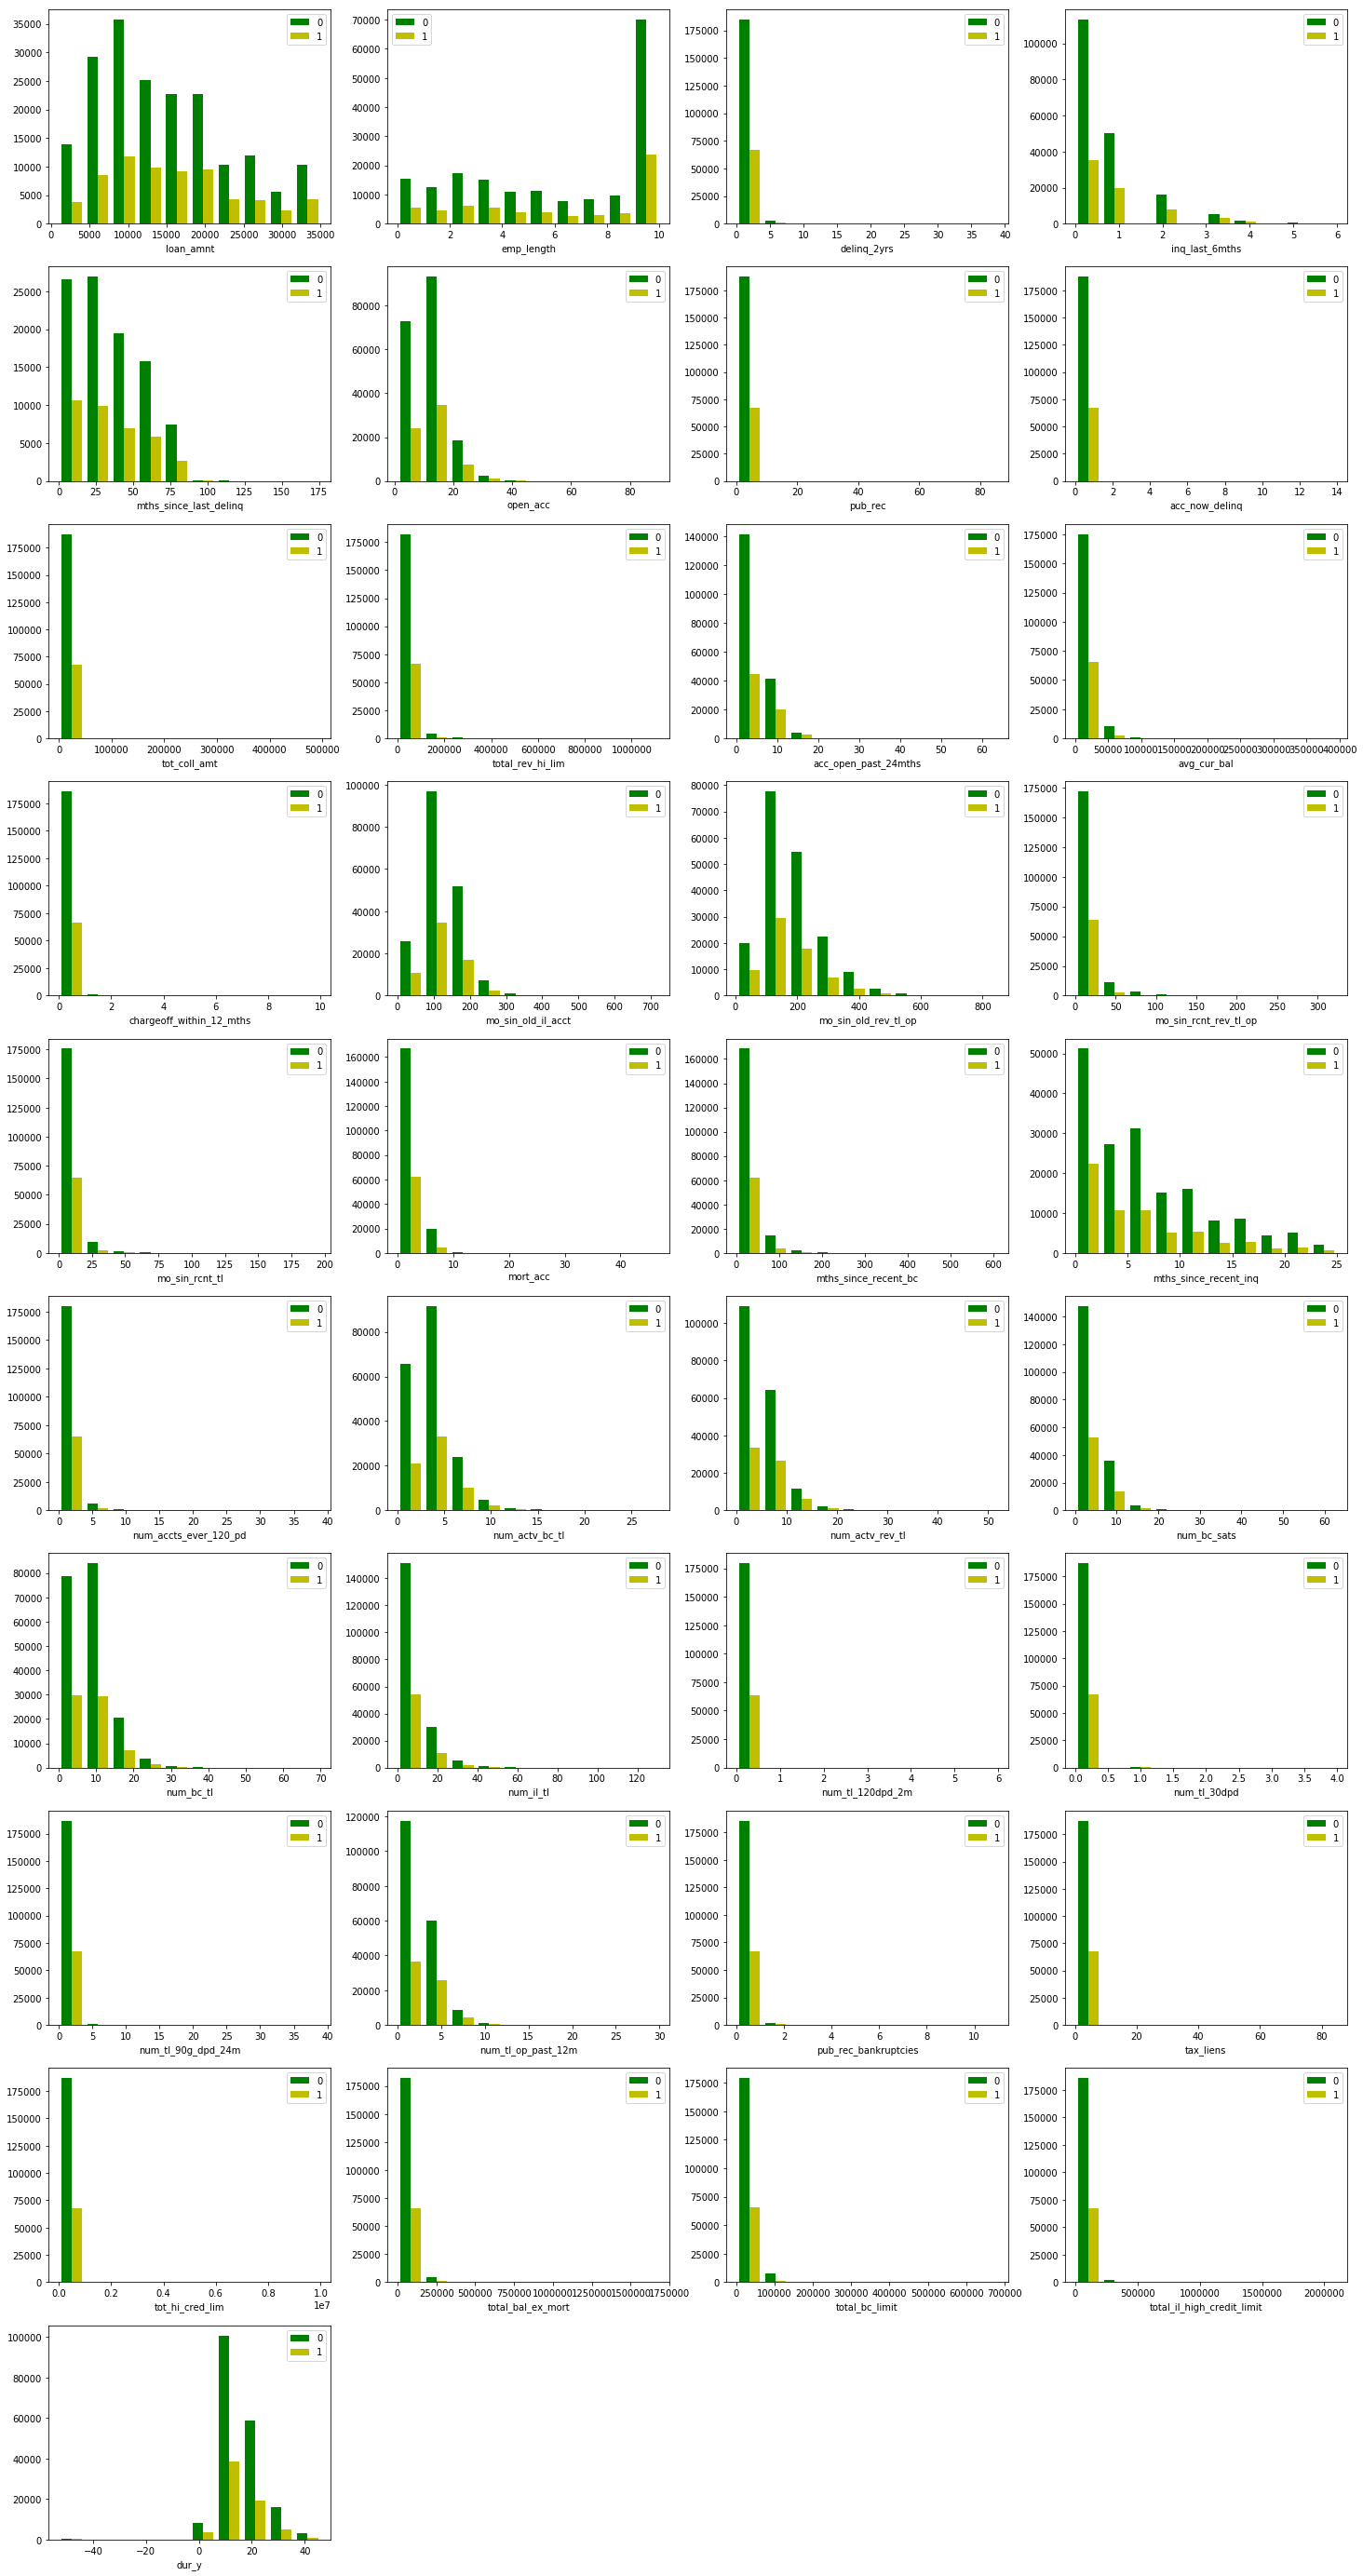

In [71]:
fig = plt.figure(figsize=(25,50))
for i in range(len(l_int)):
    ax=fig.add_subplot(10, 4, i+1)
    x1=dff[dff['label']=='0'][l_int[i]]
    x2=dff[dff['label']=='1'][l_int[i]]
    x1=x1[x1!=-999]
    x2=x2[x2!=-999]
    ax.hist([x1, x2], color=['g','y'], label=['0','1'])
    ax.set_xlabel(l_int[i])
    ax.legend()

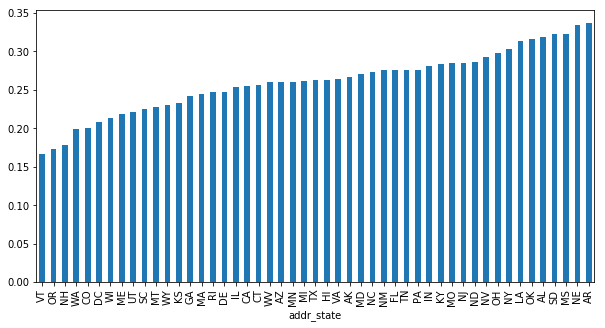

In [94]:
plt.figure(figsize=(10,5)) 
state_ct=pd.crosstab(dff.addr_state,dff.label).sort_values('1')
state_ct['default%'] = state_ct['1']/(state_ct['0'] + state_ct['1'])
state_ct['default%'].sort_values().plot(kind='bar')

In [74]:
l_object=dff.select_dtypes(include=['object']).columns.tolist()

In [96]:
state_ct.sort_values('default%',ascending=False,inplace=True)
level_4 = state_ct[state_ct['default%']>=0.3].index.tolist()
level_3 = state_ct[(state_ct['default%']>=0.26)&(state_ct['default%']<0.3)].index.tolist()
level_2 = state_ct[(state_ct['default%']>=0.2)&(state_ct['default%']<0.26)].index.tolist()
level_1 = state_ct[state_ct['default%']<0.2].index.tolist()

dff.loc[dff.addr_state.isin(level_4),'addr_state'] = 'st_level_4'
dff.loc[dff.addr_state.isin(level_3),'addr_state'] = 'st_level_3'
dff.loc[dff.addr_state.isin(level_2),'addr_state'] = 'st_level_2'
dff.loc[dff.addr_state.isin(level_1),'addr_state'] = 'st_level_1'

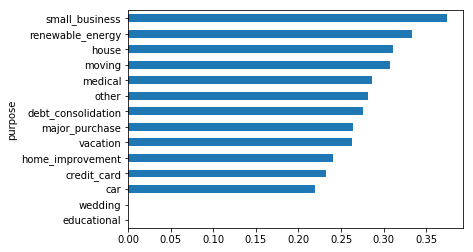

In [97]:
purpose_ct = pd.crosstab(dff.purpose,dff.label).sort_values('1',ascending=False)
purpose_ct['default%'] = purpose_ct['1']/(purpose_ct['0'] + purpose_ct['1'])
purpose_ct['loan_amnt_med'] = dff.groupby('purpose')['loan_amnt'].median()
purpose_ct['default%'].sort_values().plot(kind='barh')

In [98]:
purp_subset=['medical','moving','car','vacation','house','renewable_energy','educational','wedding']
dff.loc[dff.purpose.isin(purp_subset),'purpose'] = 'other'

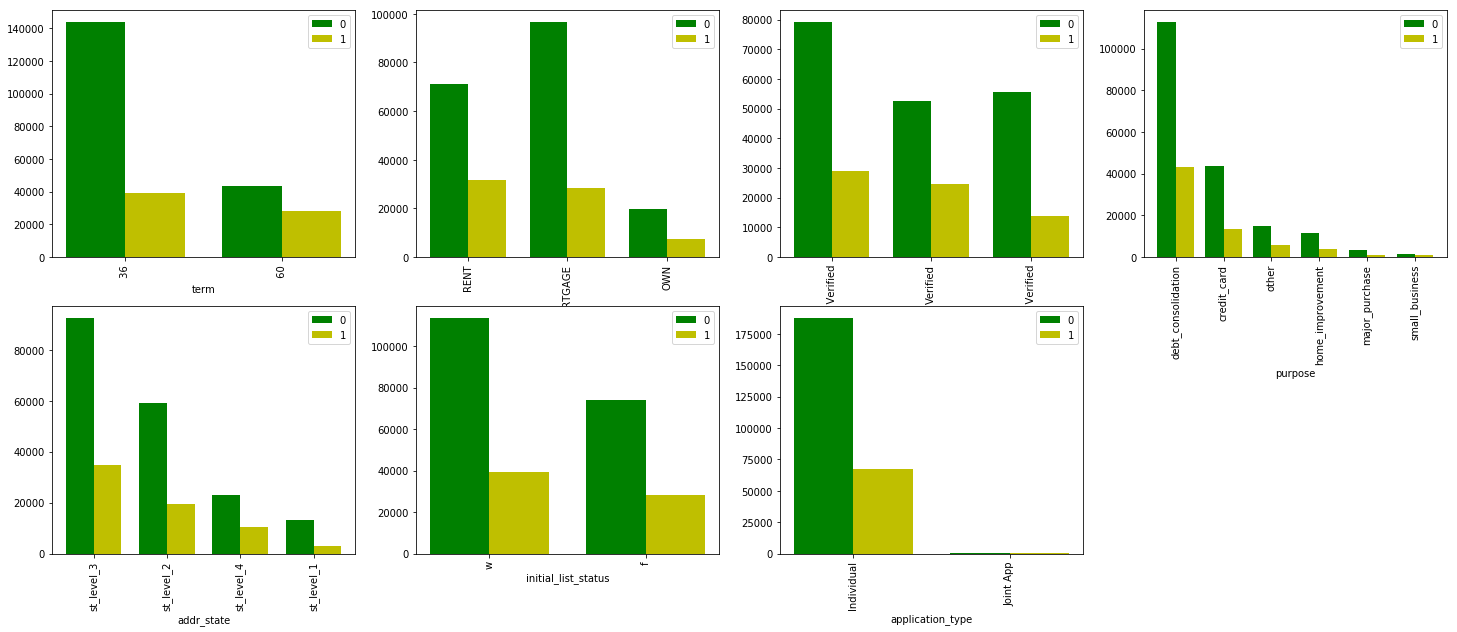

In [99]:
fig = plt.figure(figsize=(25,10))
for i in range(len(l_object[:-1])):
    ax=fig.add_subplot(2, 4, i+1,)
    fea_df=dff[l_object[i]]
    fea_ct=pd.crosstab(fea_df[fea_df!='-999'],dff.label).sort_values('1',ascending=False)
    width=0.38
    ind=np.arange(len(fea_ct.index))
    ax.bar(ind,fea_ct.iloc[:,0],width,color=['g'], label='0')
    ax.bar(ind+width,fea_ct.iloc[:,1],width,color=['y'], label='1')
    ax.set_xlabel(l_object[i])
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(fea_ct.index.tolist())
    ax.legend()
    plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')

In [101]:
import scipy.stats as sps
for i in l_object[:-1]:
    cont_tb = pd.crosstab(index=dff[i],columns=dff['label'])
    print(i,sps.chi2_contingency(cont_tb, correction=False)[:3])

term (8751.415316738741, 0.0, 1)
home_ownership (2026.8416013515534, 0.0, 2)
verification_status (2660.137314618011, 0.0, 2)
purpose (594.6595192347806, 2.8822827855387865e-126, 5)
addr_state (958.3730017718984, 1.9279983616815544e-207, 3)
initial_list_status (103.42186051503026, 2.7086939948729914e-24, 1)
application_type (4.5801301714989835, 0.03234475764416881, 1)


In [40]:
x_train, x_test, y_train, y_test = train_test_split(dff[ll_float+ll_int+lll_object],dff[['label']].astype(int),
                                                    test_size=0.2, random_state=33)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(204094, 64)
(51024, 64)
(204094, 1)
(51024, 1)


In [68]:
# https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning-docpage/
cb=catboost.CatBoostClassifier(iterations=50,eval_metric='Accuracy',random_seed=33)

In [83]:
x_train[ll_int+lll_object].columns[46:]

Index(['grade', 'sub_grade', 'home_ownership', 'addr_state',
       'initial_list_status', 'application_type', 'verification_status',
       'purpose', 'title', 'emp_title'],
      dtype='object')

In [85]:
fea_imp=pd.DataFrame(cb.feature_importances_,index=ll_int+lll_object,columns=['importance'])
fea_imp[fea_imp.importance>0].sort_values('importance',ascending=False)

,importance
sub_grade,34.612612
grade,18.421332
term,8.529297
home_ownership,6.164279
avg_cur_bal,5.781293
num_rev_tl_bal_gt_0,5.665538
mort_acc,4.242791
emp_length,3.022000
acc_open_past_24mths,2.593516
tot_hi_cred_lim,2.420311


In [84]:
cb.fit(x_train[ll_int+lll_object],y_train,list(range(46,56)))

0:	learn: 0.7542087	total: 638ms	remaining: 31.3s
1:	learn: 0.7558611	total: 1.34s	remaining: 32.1s
2:	learn: 0.7573633	total: 1.87s	remaining: 29.3s
3:	learn: 0.7578891	total: 2.51s	remaining: 28.9s
4:	learn: 0.7577239	total: 3.06s	remaining: 27.6s
5:	learn: 0.7576437	total: 3.69s	remaining: 27s
6:	learn: 0.7577789	total: 4.35s	remaining: 26.7s
7:	learn: 0.7576187	total: 4.92s	remaining: 25.8s
8:	learn: 0.7579292	total: 5.63s	remaining: 25.6s
9:	learn: 0.7577789	total: 6.22s	remaining: 24.9s
10:	learn: 0.7576638	total: 6.77s	remaining: 24s
11:	learn: 0.7579392	total: 7.42s	remaining: 23.5s
12:	learn: 0.7581695	total: 7.96s	remaining: 22.7s
13:	learn: 0.7580043	total: 8.53s	remaining: 21.9s
14:	learn: 0.7580093	total: 9.16s	remaining: 21.4s
15:	learn: 0.7581144	total: 9.8s	remaining: 20.8s
16:	learn: 0.7581295	total: 10.4s	remaining: 20.2s
17:	learn: 0.7580944	total: 11s	remaining: 19.5s
18:	learn: 0.7583047	total: 11.8s	remaining: 19.2s
19:	learn: 0.7581895	total: 12.6s	remaining: 18.

In [144]:
lll_object

['grade',
 'sub_grade',
 'term',
 'home_ownership',
 'addr_state',
 'initial_list_status',
 'application_type',
 'verification_status',
 'purpose',
 'title',
 'emp_title']

In [41]:
data=pd.concat([x_train,y_train],axis=1)

In [43]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier()
clf = clf.fit(x_train[ll_float+ll_int], y_train)

C:\Users\Yingting-PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


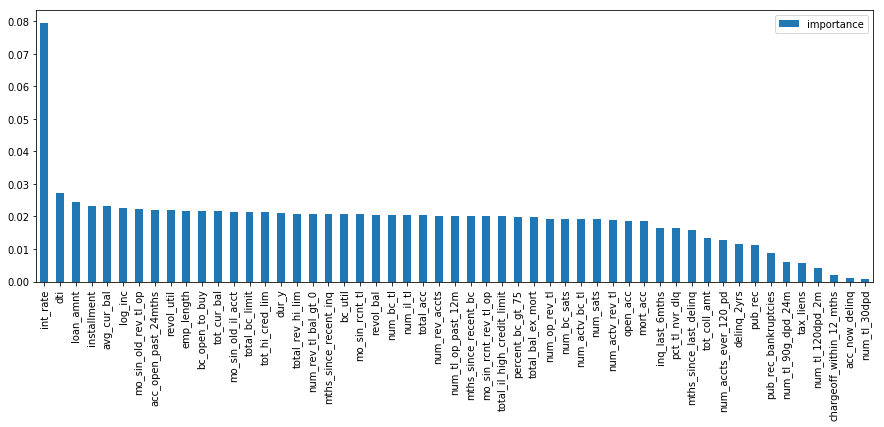

In [44]:
fea_imp=pd.DataFrame(clf.feature_importances_,index=ll_float+ll_int,columns=['importance'])
fea_imp.sort_values('importance',ascending=False).plot(kind='bar',figsize=(15,5))

In [112]:
dff

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,label,dur_y,log_inc
0,17475,36,13.99,597.17,C,C4,Software Testing Analyst,2,RENT,39750.0,...,0.0,0,0,50240,32365,21000,29240,1,13,4.599337
1,7200,36,11.48,237.36,B,B5,Legal Administrative Assistant,10,MORTGAGE,72500.0,...,0.0,0,0,189950,20256,15500,22450,0,11,4.860338
2,27500,60,14.85,652.06,C,C5,Manager,10,MORTGAGE,195000.0,...,57.1,0,0,325100,44977,55500,13200,0,14,5.290035
3,29900,60,12.88,678.49,C,C2,Corporate Insurance,10,MORTGAGE,65000.0,...,25.0,0,0,271700,42497,34000,15574,0,11,4.812913
4,30000,36,15.77,1051.31,D,D1,Vice-President,2,MORTGAGE,175000.0,...,33.3,0,0,447599,152571,43400,146568,0,18,5.243038
5,20200,60,18.49,518.35,D,D5,Manager,4,RENT,60000.0,...,25.0,1,0,84627,43224,17800,64227,1,11,4.778151
6,19000,60,14.85,450.52,C,C5,Application Analyst,9,OWN,75000.0,...,100.0,0,0,94620,48159,7500,36720,0,15,4.875061
7,28000,36,13.44,949.38,C,C3,Director of Product Development,2,OWN,125000.0,...,40.0,0,0,36100,22780,29000,0,0,15,5.096910
8,23975,60,19.89,633.73,E,E3,Principal,10,RENT,70000.0,...,100.0,0,0,74779,57655,44400,20800,1,20,4.845098
9,1500,36,6.49,45.97,A,A2,-999,-999,MORTGAGE,45000.0,...,0.0,0,0,179105,18400,12200,18050,0,28,4.653213
